# MGTA_415 Final Project: Fake News Detection

* Team member names:
    - David Yang
    - Jack Chen
* GitHub userid: rsm-day008, rsm-yuc172

### Load Required Modules And Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
import re
import string

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, matthews_corrcoef, precision_score, recall_score

In [5]:
import os
os.getcwd()

'/home/jovyan/git/MGTA_415_Fake_News_Detection'

### Import Data

In [6]:
abs_path = '/home/jovyan/git/MGTA_415_Fake_News_Detection'
fake = pd.read_csv(abs_path + "/data/Fake.csv")
true = pd.read_csv(abs_path + "/data/True.csv")
print('Fake news data: ',fake.shape)
print('True news data:',true.shape)

Fake news data:  (23481, 4)
True news data: (21417, 4)


In [7]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [8]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [9]:
fake['class'] = 1
true['class'] = 0

In [10]:
data = pd.concat([fake, true], axis=0)
data.reset_index(inplace=True)
data.drop(["index"], axis=1, inplace=True)

In [11]:
data.columns

Index(['title', 'text', 'subject', 'date', 'class'], dtype='object')

In [12]:
data.shape

(44898, 5)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [14]:
data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [15]:
# shuffle the dataset
data = data.sample(frac=1, random_state=42)

In [16]:
data.head()

,title,text,subject,date,class
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
27917,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
25007,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
32476,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


### Exploratory Data Analysis

In [17]:
class_counts = data['class'].value_counts().sort_index()
class_counts

class
0    21417
1    23481
Name: count, dtype: int64

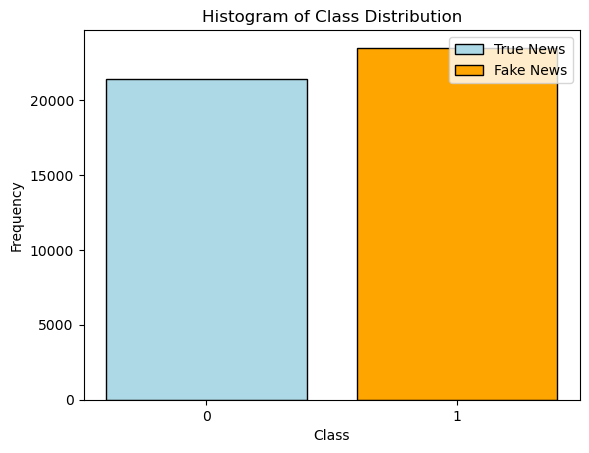

In [18]:
plt.bar(class_counts.index, class_counts.values, color=['#add8e6', '#ffa500'], edgecolor='black', label=['True News', 'Fake News'])

plt.legend(labels=['True News', 'Fake News'])
plt.xticks([0, 1])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Histogram of Class Distribution')
plt.show()

In [19]:
subject_counts = data['subject'].value_counts().sort_index()
subject_counts

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: count, dtype: int64

In [20]:
data[data['subject'] == 'worldnews']['class'].value_counts()

class
0    10145
Name: count, dtype: int64

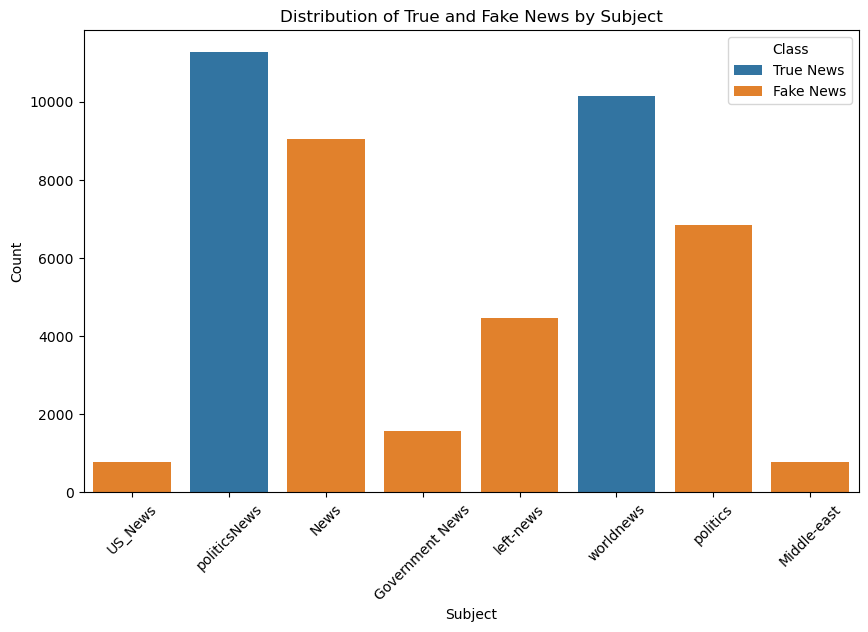

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='subject', hue='class', data=data)

plt.title('Distribution of True and Fake News by Subject')
plt.xlabel('Subject')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Class', labels=['True News', 'Fake News'])

plt.show()

We found that only subjects from "politicsNews" and "Worldnews" are true, while all other subjects are fake. \
Thus, using 'subject' feature to predict will lead to perfect prediction.

### Date Preprocessing

In [22]:
def process_news(text):
    text = text.lower()
    text = re.sub(r'https?://S+ | www\.\S+', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub('\[.*?\]', '', text)
    words=[]
    for i in text:
        if i not in string.punctuation:
            words.append(i)
    return ''.join(words)


data['text'] = data['text'].apply(process_news)
data['text'].head()

22216    21st century wire says ben stein reputable pro...
27917    washington reuters  us president donald trump ...
25007    reuters  puerto rico governor ricardo rossello...
1377     on monday donald trump once again embarrassed ...
32476    glasgow scotland reuters  most us presidential...
Name: text, dtype: object

### Base ML models (only use 'text' feature)

In [23]:
x = data['text']
y = data['class']
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2)

In [24]:
vector = TfidfVectorizer()
xtrain = vector.fit_transform(xtrain)
xtest = vector.transform(xtest)

In [25]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Classifier' : GradientBoostingClassifier(random_state=0)
}

In [26]:
import time

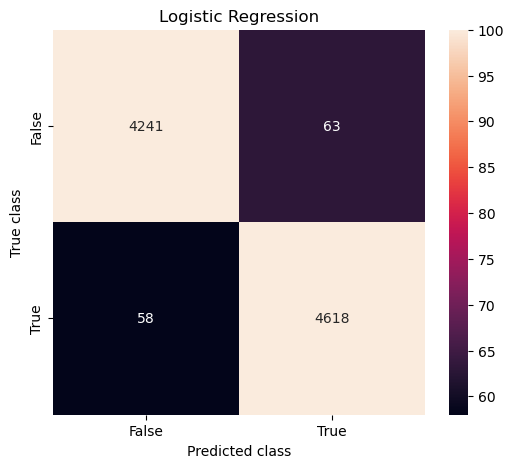

Accuracy:  0.9865256124721603
Precision:  0.9865413373210853
Recall:  0.9875962360992301
F1-Score:  0.9870685048626696
Matthews correlation coefficient:  0.9730042575821789
Time taken(in sec):  10.94
---------------------------------------------------------------------- 



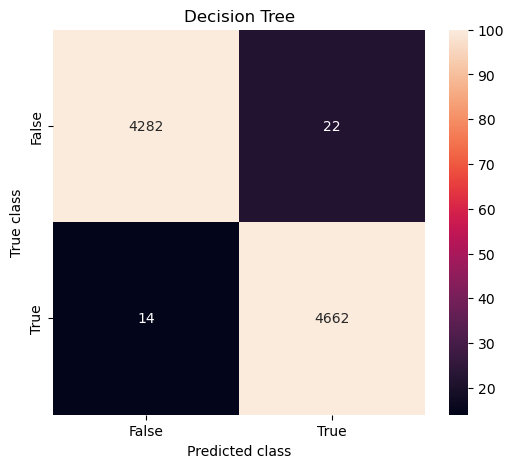

Accuracy:  0.9959910913140312
Precision:  0.9953031596925704
Recall:  0.9970059880239521
F1-Score:  0.9961538461538461
Matthews correlation coefficient:  0.9919693862280526
Time taken(in sec):  93.26
---------------------------------------------------------------------- 



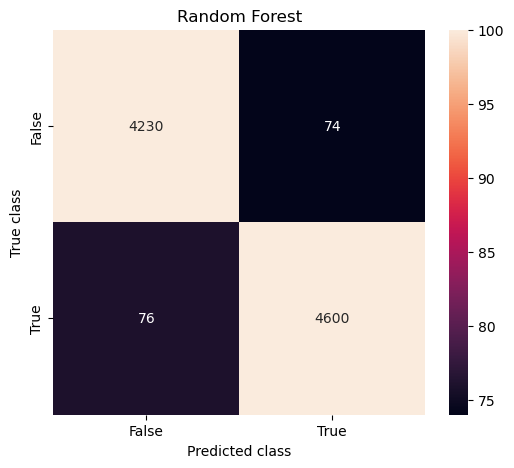

Accuracy:  0.9832962138084632
Precision:  0.9841677364142063
Recall:  0.9837467921300257
F1-Score:  0.983957219251337
Matthews correlation coefficient:  0.9665357143390284
Time taken(in sec):  195.02
---------------------------------------------------------------------- 



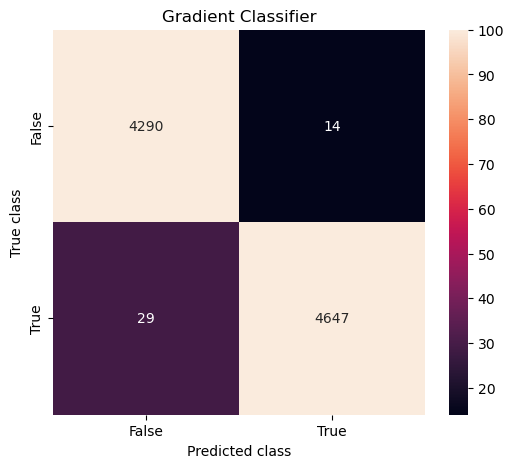

Accuracy:  0.9952115812917595
Precision:  0.9969963527140099
Recall:  0.993798118049615
F1-Score:  0.9953946663810646
Matthews correlation coefficient:  0.9904135739424158
Time taken(in sec):  792.33
---------------------------------------------------------------------- 



In [27]:
for name, model in models.items():
    start = time.time()
    model.fit(xtrain, ytrain)
    predict = model.predict(xtest)
    
    LABELS = ['False', 'True']
    conf_matrix = confusion_matrix(ytest, predict)
    plt.figure(figsize =(6,5))
    sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, vmax = 100, annot = True, fmt ="d");
    plt.title(f'{name}')
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print("Accuracy: ", accuracy_score(ytest, predict))
    print("Precision: ", precision_score(ytest, predict))
    print("Recall: ", recall_score(ytest, predict))
    print("F1-Score: ", f1_score(ytest, predict))
    print("Matthews correlation coefficient: ", matthews_corrcoef(ytest, predict))
    end = time.time()
    print("Time taken(in sec): ",round(end-start, 2))
    print('-' * 70, '\n')

### Further Study